In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import GRU
from keras import regularizers
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sn
import itertools  
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import CondensedNearestNeighbour, TomekLinks, EditedNearestNeighbours, NearMiss, RandomUnderSampler
from collections import Counter
import random
from sklearn.utils import resample
import matplotlib.pyplot as plt
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [2]:
#Function to print confusion matrix in a nice format.
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [3]:
#Importing training and testing data
train_path="C:/Users/andre/NCSA_Python/SPIN_CDC/jing_data_values.csv"
temporal_df=pd.read_csv(train_path)
test_path="C:/Users/andre/NCSA_Python/SPIN_CDC/jing_test_values.csv"
temporal_df_test=pd.read_csv(test_path)

#Importing county names
county_path="C:/Users/andre/NCSA_Python/SPIN_CDC/County_name.csv"  #CAN USE JING_DATA_KEYS?
df_county=pd.read_csv(county_path)

In [4]:
##Specifying training data parameters.
years=range(2000,2019)
num_years=1 #Unnecessary for Jing's Data structure, though hers lags by five years, initial skip one (i.e. 2018's lags are 2016-2012)

#Features/columns that will be used for prediction.
feat=list(temporal_df)
features=feat[1:14]

In [5]:
del temporal_df['Unnamed: 0']
del temporal_df_test['Unnamed: 0']

In [6]:
temporal_df.head(655)

,count_lag1,count_lag2,count_lag3,count_lag4,count_lag5,stateAvg_lag1,Incident_nominal_lag1,neigh_death_count_lag1,temp_lag1,prec_lag1,hum_lag1,gini_lag1,County_type_lag1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,1,0,0,0.223881,1,0,291.911606,3.166458,75.178524,0.519989,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0.089552,1,6,291.539614,3.900827,75.858843,0.501472,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0.119403,1,0,292.317544,3.087140,71.706429,0.536239,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0.253731,1,11,293.287243,2.213271,67.009978,0.524172,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0.164179,1,0,291.567389,3.681567,72.971491,0.477927,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,0,2,7,0,0,0.223881,1,0,292.257058,3.256280,75.457933,0.536441,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
651,5,0,2,7,0,0.089552,1,1,292.009713,3.761215,75.922392,0.511025,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
652,0,5,0,2,7,0.119403,1,0,292.840826,2.690377,71.624671,0.546820,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
653,11,0,5,0,2,0.253731,1,0,293.433240,2.674722,68.627887,0.543446,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#Checking frequency of instances for each class
dict_freq={}
for i in range(1,16):
    dict_freq[i]=len(temporal_df[temporal_df[str(i)]==1])
dict_freq

{1: 7042,
 2: 664,
 3: 312,
 4: 88,
 5: 39,
 6: 28,
 7: 13,
 8: 8,
 9: 5,
 10: 5,
 11: 5,
 12: 15,
 13: 7,
 14: 3,
 15: 2}

In [8]:
#defining the dictionary for different oversampling values, seems to be supported for all oversampling?
#Doesn't matter anyway, not useful
over_dict_list=[]
over_dict={}
for j in dict_freq.values():
    if j > 10000:
        over_dict_list.append(j)
    elif j > 1000:
        over_dict_list.append(j)
    elif j > 100:
        over_dict_list.append(j*3)
    elif j > 50:
        over_dict_list.append(j*7)
    elif j > 10:
        over_dict_list.append(j*15)
    elif j > 1:
        over_dict_list.append(j*15)

for i in range(1,16):
    over_dict[i]=over_dict_list[i-1]   

#dictionaries are only supported for random undersampling
under_dict_list=[]
under_dict={}
for j in dict_freq.values():
    if j > 10000:
        under_dict_list.append(int(j/5))
    elif j > 1000:
        under_dict_list.append(int(j/7))
    elif j > 100:
        under_dict_list.append(j)
    elif j > 10:
        under_dict_list.append(j)
    elif j > 1:
        under_dict_list.append(j)

for i in range(1,16):
    under_dict[i]=under_dict_list[i-1] 

In [9]:
#combination oversampling and undersampling
combined_dict=over_dict.copy()
combined_dict[1]=7500
combined_dict[2]=1000
#combined_dict
#over_dict

In [11]:
#A means to oversample the data - imblearn iteration

#THIS IS INITIALLY TURNED OFF FOR JING'S DATA
#TO TURN IT ON, uncomment lines 17, 18, 22, 23, and swap comment from line 3 to line 2 in next box.

#Classification of samples
temporal_df_classify = temporal_df.iloc[:,13:28]
temporal_df_values = temporal_df.iloc[:,0:13]
classify_array=[]
for j in range(0,40391):
    for i in range (0,15):
        if temporal_df_classify.iloc[j,i]==1:
            classify_array.append(i+1)

            
#over_dict for oversampling, under_dict for undersampling, combined_dict for both; swap out in undersampling option
#standard oversampling option
#ros=RandomOverSampler(sampling_strategy=over_dict) #random oversample using uneven sample sizes, for standard replace "over_dict" with "auto"
#oversampled_temporal_df,oversampled_classified_df=ros.fit_resample(temporal_df,classify_array)  #random oversample

#standard undersampling option
#be sure to adjust dictionary and variable names
undertale = RandomUnderSampler(sampling_strategy=under_dict) #undersampling with random undersample
oversampled_temporal_df,oversampled_classified_df=undertale.fit_resample(temporal_df,classify_array)

#oversampled_temporal_df

In [12]:
#Using unbalanced data
#temporal_df = temporal_df.sample(frac = 1,random_state=5) #Shuffling the data - Standard, not oversampled
temporal_df = oversampled_temporal_df.sample(frac = 1,random_state=5) #Shuffling the data - oversampled, imblearn
X_pre = temporal_df.iloc[:, 0:(len(features))]
Y_pre = temporal_df.iloc[:, (len(features)):]
X=X_pre.values
Y=Y_pre.values
temporal_df

,count_lag1,count_lag2,count_lag3,count_lag4,count_lag5,stateAvg_lag1,Incident_nominal_lag1,neigh_death_count_lag1,temp_lag1,prec_lag1,hum_lag1,gini_lag1,County_type_lag1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
7566,0,0,0,0,0,0.052632,1,2,288.961886,3.671998,76.047545,0.497831,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1423,0,0,0,0,0,0.173333,0,0,289.398978,2.334227,69.896953,0.555036,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5770,0,0,0,0,0,1.256098,0,0,291.207690,3.410320,72.703274,0.486447,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
999,0,0,0,0,0,0.088050,0,0,294.202029,2.462670,70.964268,0.467299,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5732,0,0,0,0,0,0.444882,0,2,299.028004,1.664599,70.950889,0.645013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,1,6,0,3,1,0.960784,1,5,288.262733,2.755042,73.824714,0.546467,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3046,0,0,0,0,0,0.530435,0,3,287.522367,2.885708,72.963761,0.541945,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4079,0,0,0,0,0,0.025641,0,0,281.710412,1.626275,66.581431,0.413970,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2254,0,0,0,0,0,0.225806,1,1,283.748164,2.568934,72.133511,0.613753,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
#Shows all the class labels are now equally represented
#Successfully Oversampled
y=np.argmax(Y, axis=1)
np.bincount(y)

array([7042,  664,  312,   88,   39,   28,   13,    8,    5,    5,    5,
         15,    7,    3,    2], dtype=int64)

## LSTM Implementation for classification

Hyperparameter Tuning

In [15]:
def create_network_hyp(nodes_1,lstm_node,dropout,recurrent_dropout):
    network = Sequential()
    network.add(BatchNormalization(input_shape=(num_years, len(features))))
    network.add(Dense(nodes_1, activation="tanh"))
    network.add(LSTM(lstm_node, dropout = dropout, recurrent_dropout = recurrent_dropout, activation="tanh"))
    network.add(Dense(15, activation="softmax"))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
    return network

In [16]:
#Objective function to be minimized
def objective(params):
    nodes_1=params["nodes_1"]
    dropout=params["dropout"]
    recurrent_dropout=params["recurrent_dropout"]
    lstm_node=params["lstm_node"]
    
    indices=[i for i in range(len(X))]
    indices=shuffle(indices, random_state=4)
    split_ratio=0.8    #80-20 split ratio for train-val set
    train_index=indices[0:int(split_ratio*len(X))]
    val_index=indices[int(split_ratio*len(X)):]

    
    X_pre_train = temporal_df.iloc[train_index, 0:(num_years*len(features))]
    Y_pre_train = temporal_df.iloc[train_index, (num_years*len(features)):]
    X_pre_val = temporal_df.iloc[val_index, 0:(num_years*len(features))]
    Y_pre_val = temporal_df.iloc[val_index, (num_years*len(features)):]
    X_pre_train_combine=pd.concat([X_pre_train, Y_pre_train], axis=1)
    
    #Oversampling the training data to balance the classes
    num_cl=len(X_pre_train_combine[X_pre_train_combine["1"]==1])
    df_balanced=X_pre_train_combine[X_pre_train_combine["1"]==1]
    df_balanced_train = df_balanced.sample(frac = 1, random_state=4)   #Shuffling the data
    X_pre_train = df_balanced_train.iloc[:, 0:(num_years*len(features))]
    Y_pre_train = df_balanced_train.iloc[:, (num_years*len(features)):]
    
    
    X_train=X_pre_train.values
    Y_train=Y_pre_train.values
    X_val=X_pre_val.values
    Y_val=Y_pre_val.values
    
    #Transforming input variables into LSTM input format
    X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
    X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
    Y_train=Y_train
    Y_val=Y_val
    
    #Creating model
    model=create_network_hyp(nodes_1,lstm_node,dropout,recurrent_dropout)
    Hist=model.fit(X_train, Y_train, epochs=1, validation_data=(X_val, Y_val), verbose=2, class_weight=None)
    
    #Final epoch accuracies for validation dataset
    acc_val=Hist.history["val_accuracy"][-1]

    return -acc_val   #Minimizing the objective function

In [17]:
#Declaring hyperparameter search space
space={"nodes_1": hp.choice("nodes_1", range(4,20)), "dropout": hp.uniform("dropout", 0.1, 0.4),"lstm_node":hp.choice("lstm_node", range(15,20)), "recurrent_dropout": hp.uniform("recurrent_dropout", 0.1, 0.4)}

In [18]:
# Create a trials object
tpe_trials = Trials()
# Create the algorithm
tpe_algo = tpe.suggest

In [19]:
# Run bayesian optimization for hyperparameter tuning
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=10)

Train on 5626 samples, validate on 1648 samples       
Epoch 1/1                                             
 - 1s - loss: 1.8340 - accuracy: 0.7744 - val_loss: 1.6886 - val_accuracy: 0.6905

Train on 5626 samples, validate on 1648 samples                                  
Epoch 1/1                                                                        
 - 1s - loss: 1.8023 - accuracy: 0.7353 - val_loss: 1.8652 - val_accuracy: 0.7791

Train on 5626 samples, validate on 1648 samples                                  
Epoch 1/1                                                                        
 - 1s - loss: 1.7480 - accuracy: 0.7426 - val_loss: 0.8593 - val_accuracy: 0.8234

Train on 5626 samples, validate on 1648 samples                                  
Epoch 1/1                                                                        
 - 1s - loss: 1.7463 - accuracy: 0.7057 - val_loss: 1.1847 - val_accuracy: 0.7992

Train on 5626 samples, validate on 1648 samples                   

In [20]:
tpe_results = pd.DataFrame({'Accuracy': [-x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['nodes_1'],
                            'nodes_1': tpe_trials.idxs_vals[1]['nodes_1'],
                            'dropout': tpe_trials.idxs_vals[1]['dropout'],
                            'recurrent_dropout': tpe_trials.idxs_vals[1]['recurrent_dropout']})
                            
tpe_results.tail()

,Accuracy,iteration,nodes_1,dropout,recurrent_dropout
5,0.859830,5,15,0.165592,0.218773
6,0.852549,6,2,0.327778,0.147146
7,0.794296,7,7,0.240405,0.151064
8,0.837985,8,13,0.148132,0.332574
9,0.855583,9,2,0.147838,0.221459


In [21]:
#Best parameters
print(tpe_best)

{'dropout': 0.16559244595976896, 'lstm_node': 1, 'nodes_1': 15, 'recurrent_dropout': 0.21877256453658203}


Training of model after hyperparameter tuning

In [22]:
def create_network():
    network = Sequential()
    network.add(BatchNormalization(input_shape=(num_years, len(features))))
    network.add(Dense(4, activation="tanh"))
    network.add(LSTM(14, dropout = 0.2, recurrent_dropout = 0.2, activation="tanh"))
    network.add(Dense(15, activation="softmax"))
    network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
    return network

In [23]:
#Cross-validation setup
acc_train=[]
acc_val=[]
kf = KFold(n_splits=3, shuffle=True)
for train_index, val_index in kf.split(X):   
    X_pre_train = temporal_df.iloc[train_index, 0:(num_years*len(features))]
    Y_pre_train = temporal_df.iloc[train_index, (num_years*len(features)):]
    X_pre_val = temporal_df.iloc[val_index, 0:(num_years*len(features))]
    Y_pre_val = temporal_df.iloc[val_index, (num_years*len(features)):]
    X_pre_train_combine=pd.concat([X_pre_train, Y_pre_train], axis=1)
    
    #Oversampling the training data to balance the classes
    num_cl=len(X_pre_train_combine[X_pre_train_combine["1"]==1])
    df_balanced=X_pre_train_combine[X_pre_train_combine["1"]==1]
    df_balanced_train = df_balanced.sample(frac = 1, random_state=4)   #Shuffling the data
    X_pre_train = df_balanced_train.iloc[:, 0:(num_years*len(features))]
    Y_pre_train = df_balanced_train.iloc[:, (num_years*len(features)):]
    #ros=RandomOverSampler(sampling_strategy="auto")
    #y=np.array(temporal_df.columns)
    #test_temporal_df=ros.fit_resample(temporal_df,y)
    
    
    X_train=X_pre_train.values
    Y_train=Y_pre_train.values
    X_val=X_pre_val.values
    Y_val=Y_pre_val.values
    
    #Transforming input variables into LSTM input format
    X_train = X_train.reshape(X_train.shape[0], num_years, len(features))
    X_val = X_val.reshape(X_val.shape[0], num_years, len(features))
    Y_train=Y_train
    Y_val=Y_val
    
    #Creating model
    model=create_network()
    Hist=model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val), verbose=2, class_weight=None)
    
    #Final epoch accuracies for training and validation dataset
    acc_train.append(Hist.history["accuracy"][-1])
    acc_val.append(Hist.history["val_accuracy"][-1])
    
print("Training accuracy:" + str(np.mean(acc_train)))
print("Validation accuracy:" + str(np.mean(acc_val)))
    

Train on 4710 samples, validate on 2746 samples
Epoch 1/15
 - 1s - loss: 2.1632 - accuracy: 0.7486 - val_loss: 1.7242 - val_accuracy: 0.7640
Epoch 2/15
 - 0s - loss: 0.6013 - accuracy: 0.9293 - val_loss: 0.7376 - val_accuracy: 0.8412
Epoch 3/15
 - 0s - loss: 0.2112 - accuracy: 0.9953 - val_loss: 0.7807 - val_accuracy: 0.8492
Epoch 4/15
 - 0s - loss: 0.0928 - accuracy: 1.0000 - val_loss: 0.8842 - val_accuracy: 0.8492
Epoch 5/15
 - 0s - loss: 0.0425 - accuracy: 1.0000 - val_loss: 0.9954 - val_accuracy: 0.8492
Epoch 6/15
 - 0s - loss: 0.0182 - accuracy: 1.0000 - val_loss: 1.0722 - val_accuracy: 0.8492
Epoch 7/15
 - 0s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 1.1266 - val_accuracy: 0.8492
Epoch 8/15
 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.1708 - val_accuracy: 0.8492
Epoch 9/15
 - 0s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.2189 - val_accuracy: 0.8492
Epoch 10/15
 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.2622 - val_accuracy: 0.8492
Epoch 11/15
 - 0s - l

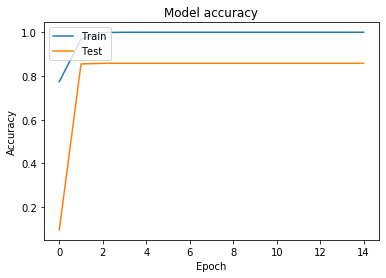

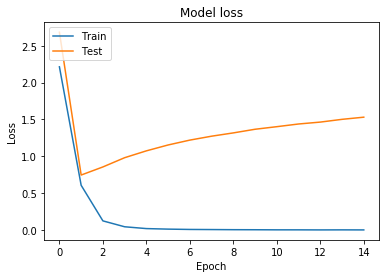

In [24]:
# Plot training & validation accuracy values
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
X_test=temporal_df_test.values
X_test = X_test.reshape(X_test.shape[0], num_years, len(features))

In [26]:
#Predicting value for train, val, and test datasets
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)
pred_test=model.predict(X_test)
#pred_all=model.predict(X_all)

In [27]:
#Converting probabilities to class labels
pred_train_class=np.argmax(pred_train, axis=1)+1
pred_train_class=list(map(lambda x: str(x), pred_train_class))
pred_val_class=np.argmax(pred_val, axis=1)+1
pred_val_class=list(map(lambda x: str(x), pred_val_class))
pred_test_class=np.argmax(pred_test, axis=1)+1

In [28]:
true_train_class=np.argmax(Y_train, axis=1)+1
true_train_class=list(map(lambda x: str(x), true_train_class))
true_val_class=np.argmax(Y_val, axis=1)+1
true_val_class=list(map(lambda x: str(x), true_val_class))

In [29]:
labels = [str(i) for i in range(1,16)]
cm_train = confusion_matrix(true_train_class, pred_train_class , labels)
cm_val = confusion_matrix(true_val_class, pred_val_class , labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [30]:
print_cm(cm_train, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 4687.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        6   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        7   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        8   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        9   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

In [31]:
print_cm(cm_val, labels)

              1     2     3     4     5     6     7     8     9    10    11    12    13    14    15 
        1 2355.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        2 240.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        3  84.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        4  27.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        5   6.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        6  12.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        7   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        8   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0 
        9   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

In [32]:
#Evaluation metrics for valdation dataset
print(metrics.classification_report(true_val_class, pred_val_class))

              precision    recall  f1-score   support

           1       0.86      1.00      0.92      2355
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       240
           3       0.00      0.00      0.00        84
           4       0.00      0.00      0.00        27
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3

    accuracy                           0.86      2745
   macro avg       0.07      0.08      0.07      2745
weighted avg       0.74      0.86      0.79      2745



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generating test data frame results

In [33]:
result_path="C:/Users/andre/NCSA_Python/SPIN_CDC/WNV_forecasting_template_(4-20-2020).csv"
df_result=pd.read_csv(result_path)
df_final=pred_test

In [34]:
df_final_list = np.array(df_final).tolist()

In [35]:
values={}
for i in range(len(df_final_list)):
    values["{0}".format(i+1)]=df_final_list[i]
values_df = pd.DataFrame.from_dict(values,'index')

rename={}
for i in range(0,15):
    rename[i]="{0}".format(i+1)

counties=[]
counties_new=[]
counties=df_county.values.tolist()
for i in counties:
    counties_new.append(counties[counties.index(i)][0])
    
valu_df_re = values_df.rename(rename,axis='columns')
valu_df_re["County"]=counties_new
cols=valu_df_re.columns.tolist()
cols = cols[-1:] + cols[:-1]
valu_df_re=valu_df_re[cols]

valu_df_re.to_csv("C:/Users/andre/NCSA_Python/SPIN_CDC/Bin_Values_7_21_2020_JING_under1.csv", index=False)